In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

2022-05-31 11:31:34.797008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 11:31:34.797023: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
omni_train = tfds.load("omniglot", split="test", as_supervised=True, shuffle_files=False)
omni_spy = tfds.load("omniglot", split="small1", as_supervised=True, shuffle_files=False)
omni_test = tfds.load("omniglot", split="small2", as_supervised=True, shuffle_files=False)

2022-05-31 11:31:35.961165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-31 11:31:35.961196: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-31 11:31:35.961229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LXMU-GNHP733): /proc/driver/nvidia/version does not exist
2022-05-31 11:31:35.961432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    return image, label

In [4]:
train_data = {}
#otrain = omni_train.take(11000)
for image, label in omni_train.take(11000).map(preprocess_image):
    image = image.numpy()
    label = str(label.numpy())
    if label not in train_data:
        train_data[label] = []
    train_data[label].append(image)
train_labels = list(train_data.keys())

2022-05-31 11:31:37.565114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
len(train_labels)

659

In [6]:
val_data = {}
for image, label in omni_train.skip(11000).map(preprocess_image):
    image = image.numpy()
    label = str(label.numpy())
    if label not in val_data:
        val_data[label] = []
    val_data[label].append(image)
val_labels = list(val_data.keys())

In [7]:
len(val_labels)

638

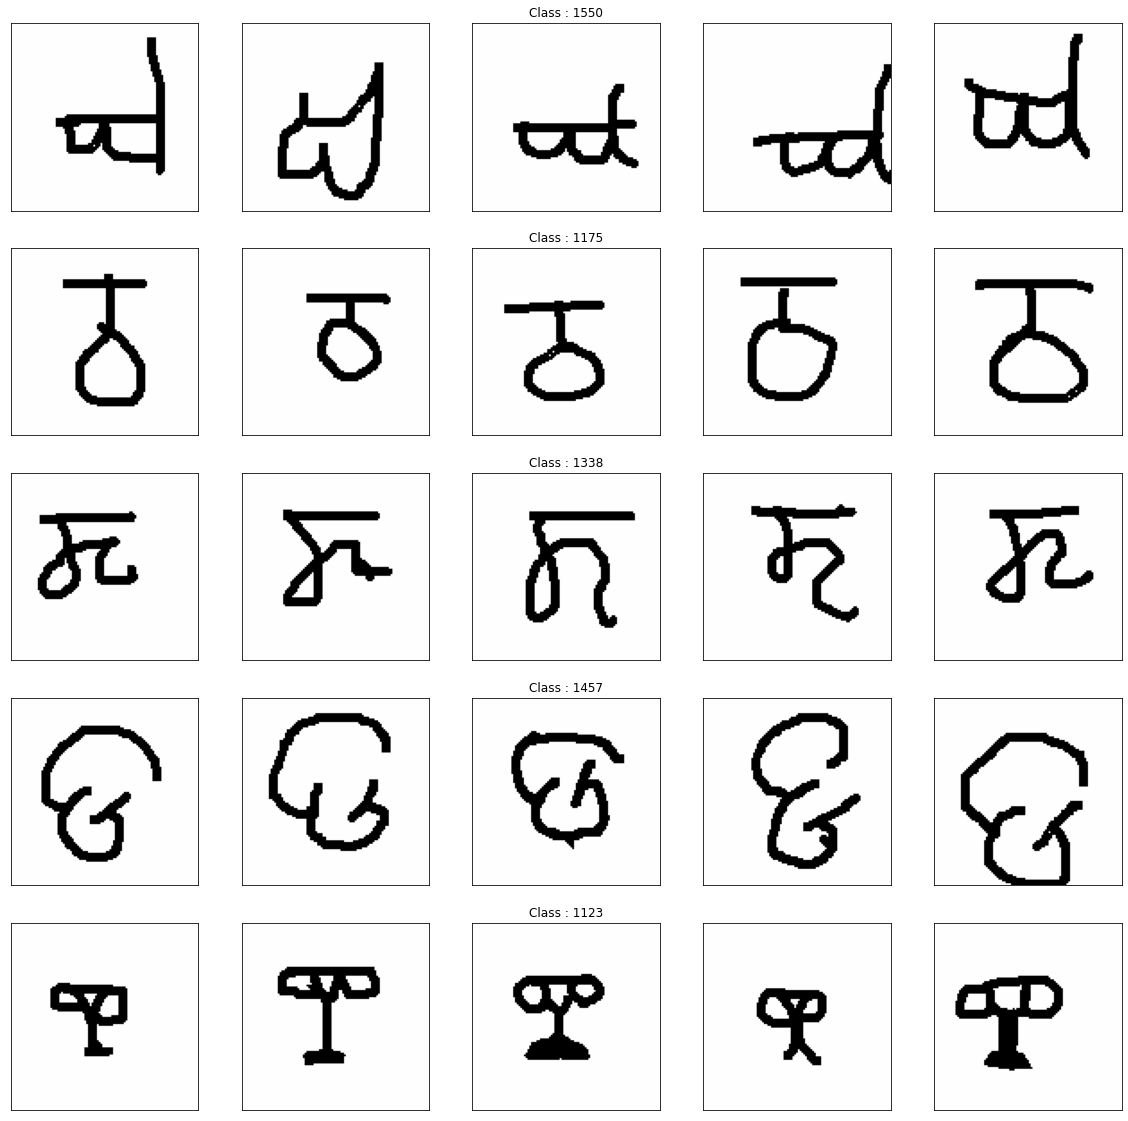

In [8]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

In [9]:
input_shape = train_data[train_labels[0]][1].shape
print(input_shape)

(105, 105, 1)


In [27]:
def get_on_device_model():
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters=32, kernel_size=7, activation="relu")(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=3, strides=3)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=32, kernel_size=7, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(units=256, activation="relu")(x)
    
    return input_layer, x

In [28]:
get_on_device_model()

(<KerasTensor: shape=(None, 105, 105, 1) dtype=float32 (created by layer 'input_10')>,
 <KerasTensor: shape=(None, 1, 1, 256) dtype=float32 (created by layer 'dense_15')>)

In [29]:
def get_server_model(device_model):
    output_layer = layers.Dense(units=256, activation="relu")(device_model)
    x = layers.Flatten()(output_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(units=50, activation="softmax")(x)
    return x

In [33]:
inputs, on_device_model = get_on_device_model()
server_model = get_server_model(on_device_model)

def get_target_model():
    model = keras.Model(inputs=inputs, outputs=server_model)
    model.compile()
    return model  

In [34]:
model = get_target_model()

In [35]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 105, 105, 1)]     0         
                                                                 
 conv2d_40 (Conv2D)          (None, 99, 99, 32)        1600      
                                                                 
 batch_normalization_40 (Bat  (None, 99, 99, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 33, 33, 32)       0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 33, 33, 32)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 27, 27, 32)        5020

In [37]:
optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()
train_loss = keras.metrics.Mean(name="train_loss")
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")